# Homework: GCFS prediction

Stine Fohrmann

![](plots/homework-gcfs-prediction.png)

## Exploring the data set

tas_dm_GCFS2-1_144x72_r1i3p3_199003-201908.nc:

- tas

- dm

- GCFS2-1 -> German Climate Forecast System 2.1

- 144x72 -> lon: 144 (0 to 357.5), lat: 72 (-88.75 to 88.75)

- r1i3p3

- 199003-201908 -> daily resolution (14:56) from 1990-03-01 to 2019-08-31 (only Mar-Aug (MAMJJA))

- temperature variable: temp2


data/tas_dm_GCFS2-1_144x72_r1i8p2_199008-202402.nc:

- 144x72 -> lon: 144 (0 to 357.5), lat: 72 (-88.75 to 88.75)

- 199008-202402 -> daily resolution from 1990-08-01 to 2024-02-31 (only Aug-Feb (ASONDJF))

- temperature variable: var167


data/tas_dm_GCFS2-1_144x72_r1i11p3_198211-202004.nc:

- 144x72 -> lon: 144 (0 to 357.5), lat: 72 (-88.75 to 88.75)

- 198211-202004 -> daily resolution from 1982-11-01 to 2020-04-30 (only Nov-Apr (NDJFMA))

- temperature variable: temp2


In [1]:
# Imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import pandas as pd
from functions import *
from datetime import datetime

In [2]:
# Read data (temps in K)
data_era5 = read_from_file()
data_gcfs = read_from_file('data/tas_dm_GCFS2-1_144x72_r1i3p3_199003-201908.nc')
# data_era5

In [3]:
# Select GCFS data around Oslo (1990-03 - 2019-08) (in K)
data_gcfs_oslo = get_data_subset(data_gcfs, start_date='1990-03', end_date='2019-08')
data_era5_oslo = get_data_subset(data_era5)

# Calculate reference climatology (1940-1969) from ERA5 (in K)
climatology_era5 = compute_climatology(data_era5_oslo)

# Calculate climatology from GCFS data
climatology_gcfs = compute_climatology(data_gcfs_oslo)


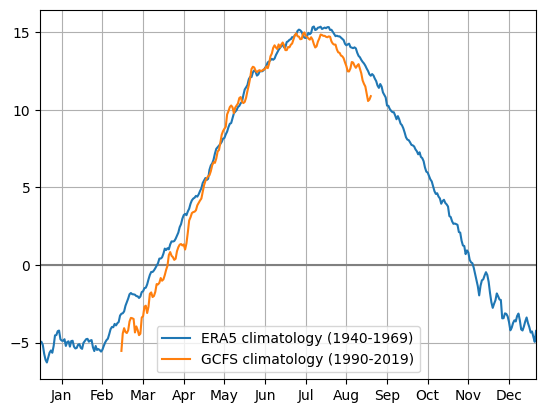

In [4]:
plt.axhline(y=0, c='grey')

plt.plot(climatology_era5.dayofyear, climatology_era5.temp2 - 273.15, label='ERA5 climatology (1940-1969)')
plt.plot(climatology_gcfs.dayofyear, climatology_gcfs.temp2 - 273.15, label='GCFS climatology (1990-2019)')

xticks = climatology_era5.dayofyear.values[15::30]
labels = [datetime.strptime(f'2000-{day}', '%Y-%j').strftime('%b') for day in xticks]
plt.xticks(ticks=xticks, labels=labels)

plt.xlim(xmin=0, xmax=366)

plt.grid()
plt.legend()
plt.show()

In [5]:
# Count predicted HWDs in JJA from GCFS data (1990-2019)
gcfs_hwd_yrs, gcfs_hwd = count_hwd(data_gcfs_oslo, climatology_gcfs, 
    start_year=1990,
    end_year=2019,
    start_month=6,
    end_month=8
    )

# Predicted summer HWDs from GCFS using ERA5 climatology (for testing)
# gcfs_hwd_yrs_test, gcfs_hwd_test = count_hwd(data_gcfs_oslo, climatology_era5, 
#     start_year=1990,
#     end_year=2019,
#     start_month=6,
#     end_month=8
#     )

In [6]:
# Count observed HWDs in JJA from ERA5 data -> climate index
era5_hwd_yrs, era5_hwd = count_hwd(data_era5_oslo, climatology_era5,
    start_month=6,
    end_month=8
)

In [7]:
# Count observed HWD in MAM from ERA5 -> persistence prediction
hwd_MAM_years, hwd_MAM = count_hwd(data_era5_oslo, climatology_era5,
    start_month=3,
    end_month=5
)

In [8]:
# Climatology prediction
# Count summer HWDs in reference period (1940-1969)
hwd_climatology_JJA_years, hwd_climatology_JJA = count_hwd(data_era5_oslo, climatology_era5,
    start_year=1940,
    end_year=1969,
    start_month=6,
    end_month=8
)

# Calculate average number of summer HWDs
hwd_avg = hwd_climatology_JJA.mean()
hwd_avg_array = np.full(len(era5_hwd_yrs), hwd_avg)

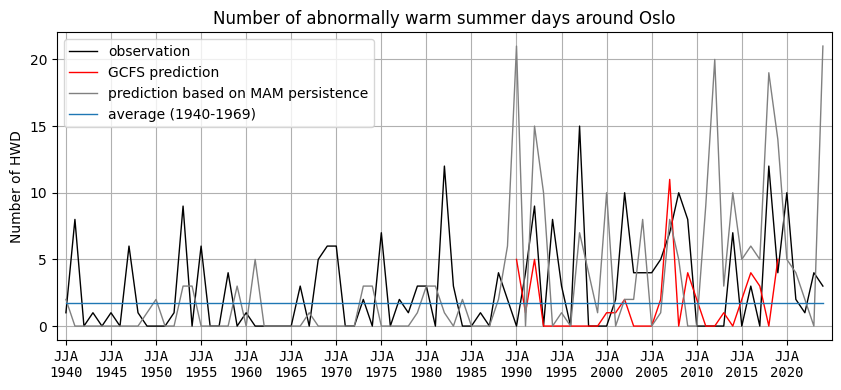

In [14]:
# Plot time series of JJA HWD
plt.figure(figsize=(10,4))

# Plot observed summer HWD (ERA5)
plt.plot(era5_hwd_yrs, era5_hwd, '-', c='k', lw=1, label='observation')

# Predicted summer HWDs (GCFS)
plt.plot(gcfs_hwd_yrs, gcfs_hwd, '-', c='red', lw=1, label='GCFS prediction')

# Prediction based in MAM peristence
plt.plot(hwd_MAM_years, hwd_MAM, '-', c='grey', lw=1, label='prediction based on MAM persistence')

# Plot prediction based on May persistence
# plt.plot(years, hwd_May, '-', lw=1, label='predicted HWD in JJA')

# Plot prediction based on average number of summer HWD
plt.plot(era5_hwd_yrs, hwd_avg_array, '-', lw=1, label='average (1940-1969)')

# Plot prediction based on average number of summer HWDs of previous 5 years
# plt.plot(years, previous_years_prediction, '-', label=f'average (previous {num_years} years)')


# Fig settings
plt.title('Number of abnormally warm summer days around Oslo')
plt.ylabel(r'Number of HWD')
# plt.xlabel(r'time')
plt.grid()
plt.legend()
arial_font = {'fontname': 'monospace'}
plt.xticks(era5_hwd_yrs[::5], labels=[f'JJA\n{y}' for y in era5_hwd_yrs[::5]], **arial_font)
plt.xlim(xmin=1939, xmax=2025)

plt.savefig('plots/homework-gcfs-prediction.png')
plt.show()


## Forecast skill

In [10]:
# Skill of prediction based on MAM persistence
rmse_persist = RMSE(Ok=era5_hwd, Yk=hwd_MAM)
acc_persist  = ACC(Ok=era5_hwd, Oavg=era5_hwd.mean(), Yk=hwd_MAM, Yavg=hwd_MAM.mean())

# Skill of climatology prediction
rmse_climate = RMSE(Ok=era5_hwd, Yk=hwd_avg_array)

# Skill of GCFS model prediction
# Select same time scale of index from ERA5 as for GCFS
Ok = era5_hwd[gcfs_hwd_yrs[0]-1940:gcfs_hwd_yrs[-1]-1940+1]
rmse_gcfs = RMSE(Ok=Ok, Yk=gcfs_hwd)
acc_gcfs  = ACC(Ok=Ok, Yk=gcfs_hwd)

# Print 
print(f'Persistence prediction\nRMSE = {rmse_persist.round(2)}\nACC  = {acc_persist.round(2)}\n--------------')
print(f'Climatology prediction\nRMSE = {rmse_climate.round(2)}\n--------------')
print(f'GCFS model prediction\nRMSE = {rmse_gcfs.round(2)}\nACC  = {acc_gcfs.round(2)}\n--------------')

Persistence prediction
RMSE = 5.65
ACC  = 0.17
--------------
Climatology prediction
RMSE = 3.68
--------------
GCFS model prediction
RMSE = 5.22
ACC  = 0.09
--------------
